In [16]:
# Import Denpendencies
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import scipy.linalg as spl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import time
import h5py
from tl_utils import *

# Problem Setup
We consider the one-dimensional diffusion equation with point and distributed source terms:

$$
\frac {\partial h}{\partial t} = \frac{\partial}{\partial x} \left[ k(x) \frac{\partial h}{\partial x} \right]
+ f(x,t) + q(t)\delta(x-x^*) , \quad x \in (0, L), \quad t \in (0, T]
$$

subject to the initial condition

$$
h(x,t=0)= h_0 , \quad x \in (0, L),
$$

and the boundary conditions

$$
h(x=0,t)= h_l, \quad h(x=L,t)= h_r , \quad t \in [0, T],
$$

where $L = 1$, $T=0.03$, and $\delta(\cdot)$ is the Dirac delta function. The location of the point source $x^*$ is known and fixed at $x^* = 0.25L$. The space-dependent diffusion parameter $k(x) = \exp(y(x))$ is known and generated as a realization of the exponential of a Gaussian process. $
C_y(x,x') = \sigma^2_y \exp \left[ -\frac{(x-x')^2}{l_y^2}\right]
$ is the squared exponential covariance function with $\sigma^2_y=0.6$ and the correlation length $l_y=0.5L$.

We want to train a surrogate model that has $\bm\xi$, the reduced-space representation of all control variables (i.e., $f,Q,h_0,h_l,h_r$) as input, and PDE solution as the output:

$$
\hat{h}(x,t|f,Q,h_0,h_l,h_r) =
\mathcal{KL} \left[\overline{h}^s,  \bm\psi_h^s, \bm{W}^s\bm\xi \right],
$$

Here, $\overline{h}^s$,  $\bm\psi_h^s$, $\bm{W}^s$ are all learned from the source training data. We will see in the following that all these parameters can be transferred and used for prediction in the target condition, except that <span style="color:blue"> mean h(x,t) needs to be retrained by solving the mean-field PDE under the target condition. <span>

Notes:
- We consider three target conditions (T1, T2, and T3). In target problem T1, the mean function of the target control variables differs from that of the source (the variances and correlation lengths/times are the same under source and target conditions). In target problem T2, the mean target control variables are as in T1 and the correlation lengths/times of the target control variables are scaled by a factor of $\alpha$ compared to the source as  $\left[ l_f^t, \tau_f^t, \tau_q^t \right] = \alpha \left[ l_f^s, \tau_f^s, \tau_q^s \right]$.  In target problem T3, the variances of the target control variables are scaled by a factor of $\beta$ relative to the source as $ \left[ \sigma^{2,t}_f, \sigma^{2,t}_q \right] = \beta \left[ \sigma^{2,s}_f, \sigma^{2,s}_q \right]$. 
- Generally, the number of KLD terms can be different for source and target conditions, when target covariance change, it may be wise to always choose larger terms for source KLE. 

In [ ]:
# Problem setup
rand_seed = 6
rng = np.random.default_rng(rand_seed)

T = 0.03
L = 1
Nx = 30 - 1 # Number of cells in space
Nt = 250 - 1 # Number of cells in time
Nr = (Nt + 1)*(Nx + 1)
dx = L/Nx      
dt = T/Nt         
tr = np.arange(Nt + 1)*dt # Time nodes [0,dt,2dt,..., T] 
xr = np.arange(Nx + 1)*dx # Space nodes [0, dx,2dx,..., L] 
XX, TT = np.meshgrid(xr, tr) 
txr = np.column_stack((TT.ravel(), XX.ravel())) 
xtr = np.column_stack((XX.ravel(), TT.ravel())) 

load_data = False
save_data = False
Nfxi_s = 200  # Number of KL terms in the f(x,t) expansions 
NQxi_s = 40  # Number of KL terms in the Q(t) expansions 
Nfxi_t = 200  # Number of KL terms in the f(x,t) expansions 
NQxi_t = 40  # Number of KL terms in the Q(t) expansions 
Nuxi = 40  # Number of KL terms in the u(x,t) expansions 

Nmc_s = 1000 # Number of training data for the source
Nmc_t = 1000 # Number of training data for the target
Nref_s = 100 # Number of test data for the source
Nref_t = 100 # Number of test data for the target

x_star = 0.25  # location of the source term
idx_star = np.argmin(np.abs(xr - x_star)) # cell index of the source term

cor_len_scale = 1 # scaling factor for correlation length (For TL2)
var_scale = 1 # scaling factor for variance (For TL3)
mean_shift = 0 # mean shift for IBCs (does not affect TL)

# 1D reference parameter field, assumed to be deterministic and fixed
Disp = 10
gammaY, varY = 0.5, 0.6 * L
CovY = varY * np.exp(- (xr[:, np.newaxis] - xr)**2 / gammaY**2)
PhiY, LambdaY = get_eigenpairs(CovY)  
xiY_ref = rng.standard_normal(Nx + 1) 
K_ref = Disp * np.exp(PhiY @ xiY_ref)

# Generate random input data
Random IBC variables are uniformly distributed:
$H_0 \sim \mathcal{U}(h_0^{\text{min}}, h_0^{\text{max}})$, 
$H_l \sim \mathcal{U}(h_l^{\text{min}}, h_l^{\text{max}})$, 
$H_r \sim \mathcal{U}(h_r^{\text{min}}, h_r^{\text{max}})$.

The input parameters $h'_0$, $h'_r$, and $h'_l$ are found by mean-substracting:

$$
h'_0 = h_0 - \overline{h}_0, \quad h'_l = h_l - \overline{h}_l, \quad h'_r = h_r - \overline{h}_r.
$$



In [18]:
##################### random initial and boundary conditions ##################

ul_max = 1 + 0.2 * L
ul_min = 1 + 0.025 * L
ul_mc_s = rng.uniform(ul_min, ul_max, Nmc_s) #[1.025, 1.2]
ul_mc_s_mean = (ul_max + ul_min)/2
ul_mc_s_prime = ul_mc_s - ul_mc_s_mean
ul_mc_t = rng.uniform(ul_min + mean_shift, ul_max + mean_shift, Nmc_t) 
ul_mc_t_mean = ul_mc_s_mean + mean_shift

ur_max = 1 - 0.025 * L
ur_min = 1 - 0.2 * L
ur_mc_s = rng.uniform(ur_min, ur_max, Nmc_s) #[0.8, 0.975]
ur_mc_s_mean = (ur_max + ur_min)/2
ur_mc_s_prime = ur_mc_s - ur_mc_s_mean
ur_mc_t = rng.uniform(ur_min + mean_shift, ur_max + mean_shift, Nmc_t) 
ur_mc_t_mean = ur_mc_s_mean + mean_shift

u0_max = 1 + 0.025 * L
u0_min = 1 - 0.025 * L
u0_mc_s = rng.uniform(u0_min, u0_max, Nmc_s) #[0.975, 1.025]
u0_mc_s_mean = (u0_max + u0_min)/2
u0_mc_s_prime = u0_mc_s - u0_mc_s_mean
u0_mc_t = rng.uniform(u0_min + mean_shift, u0_max + mean_shift, Nmc_t) 
u0_mc_t_mean = u0_mc_s_mean + mean_shift

# reference values for source and target
ul_ref_s = rng.uniform(ul_min, ul_max, (Nref_s,)) 
ur_ref_s = rng.uniform(ur_min, ur_max, (Nref_s,)) 
u0_ref_s = rng.uniform(u0_min, u0_max, (Nref_s,))

ul_ref_t = rng.uniform(ul_min, ul_max, (Nref_t,)) + mean_shift 
ur_ref_t = rng.uniform(ur_min, ur_max, (Nref_t,)) + mean_shift 
u0_ref_t = rng.uniform(u0_min, u0_max, (Nref_t,)) + mean_shift

ul_ref_s_prime = ul_ref_s - ul_mc_s_mean
ur_ref_s_prime = ur_ref_s - ur_mc_s_mean
u0_ref_s_prime = u0_ref_s - u0_mc_s_mean

ul_ref_t_prime = ul_ref_t - ul_mc_t_mean
ur_ref_t_prime = ur_ref_t - ur_mc_t_mean
u0_ref_t_prime = u0_ref_t - u0_mc_t_mean

The distributed source function $f(x,t)$, the point source (pumping) rate $Q(t)$, are control variables defined by the stochastic processes $F(x,t) \sim \mathcal{GP}\{ \overline{f}(x,t), C_f(x,x',t,t') \}$, 
$Q(t) \sim \mathcal{GP}\{ \overline{q}(t),C_q(t,t') \}$.

The squared exponential covariances are also assumed:  $C_f(x,x',t,t') = \sigma^2_f \exp \left[ -\frac{(x-x')^2}{l_f^2} - \frac{(t-t')^2}{\tau_f^2} \right]$ and  $C_q(t,t') = \sigma^2_q \exp \left[-\frac{(t-t')^2}{\tau_q^2} \right]$ 

$\overline{f}^s(x, t) = 0.5 \sin\left(2 \pi x \cos\left(10 \pi t\right)\right)$, $\sigma^{2,s}_f =10$, $l_f^s=0.5L$, $\tau_f^s=0.5T$

$ \overline{q}^s(t) = \sin\left( 2 \pi t/T \right)$, $\sigma^{2,s}_q=1$, $\tau_q^s=0.1T$ 

- TL1: $\overline{f}^t(x,t) = 1.2 \left[\exp(x) + t^3 - tx \right]$, $\overline{q}^t(t) = \cos\left( 2 \pi t/T \right)$, variance and correlation length are the same.
- TL2: $\left[ l_f^t, \tau_f^t, \tau_q^t \right] = \alpha \left[ l_f^s, \tau_f^s, \tau_q^s \right]$
- TL3: $ \left[ \sigma^{2,t}_f, \sigma^{2,t}_q \right] = \beta \left[ \sigma^{2,s}_f, \sigma^{2,s}_q \right]$

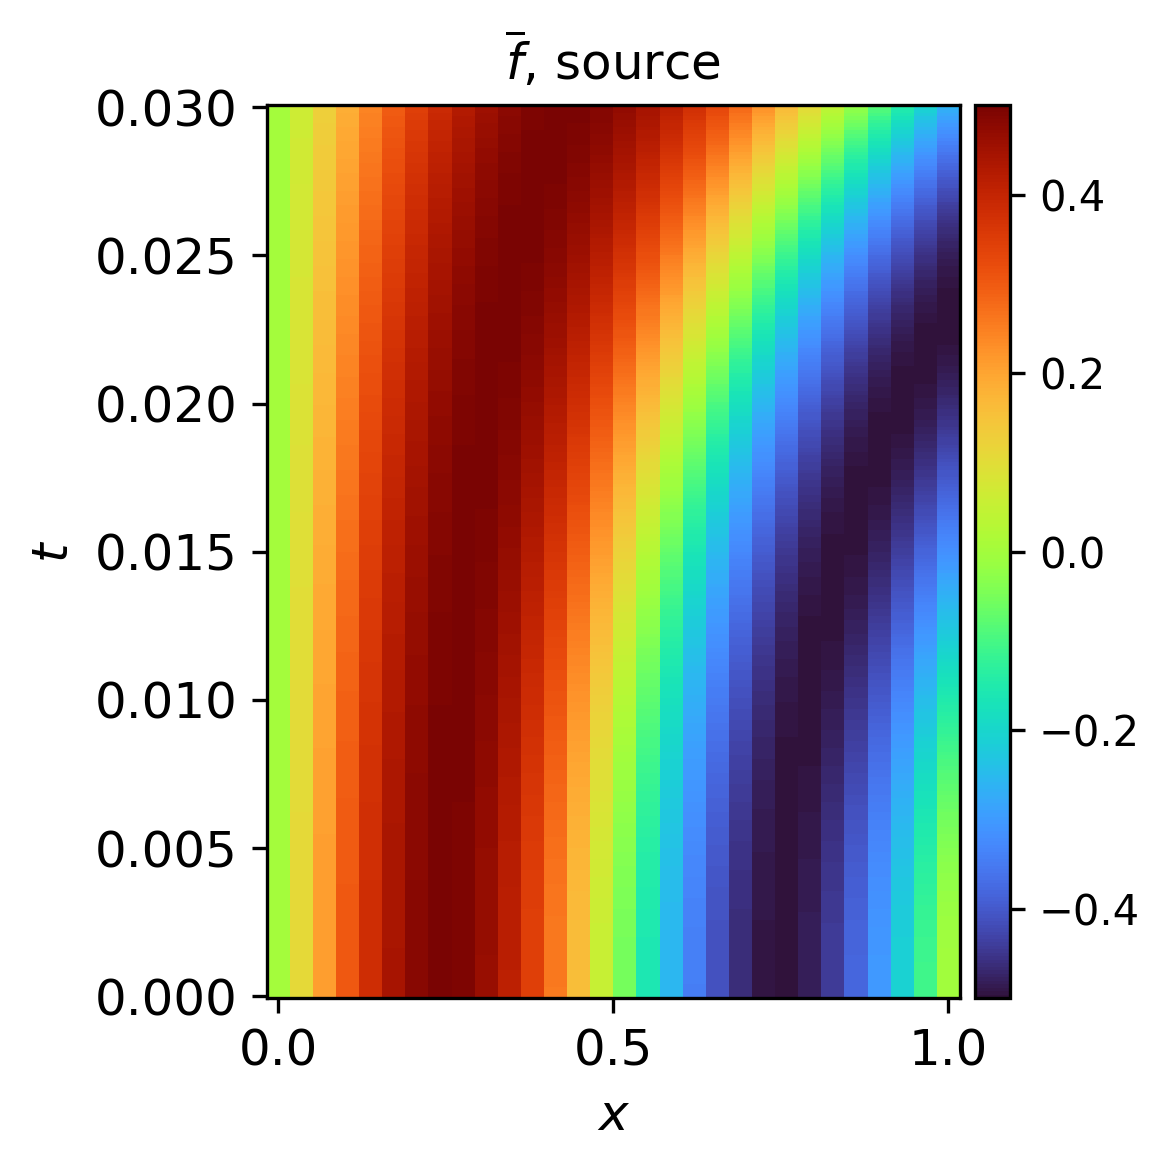

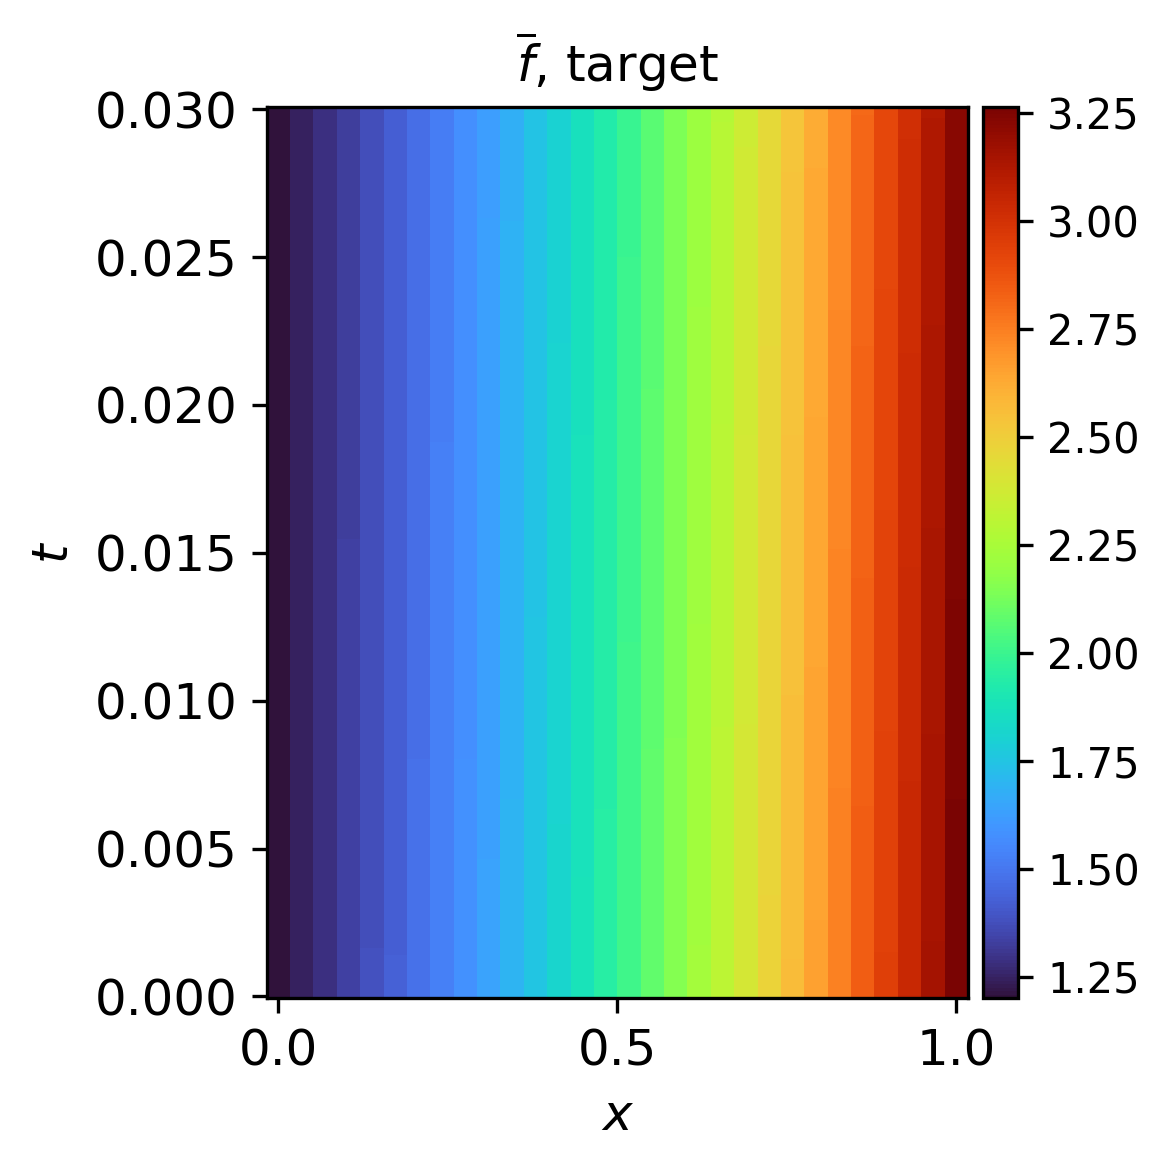

In [ ]:
############################## f(x,t) dataset ##############################

meanf_s = 0.5*np.sin(2 * np.pi * XX * np.cos(10 * np.pi * TT))
meanf_t = 1.2*(np.exp(XX) + TT**3 - XX * TT)
plot_field_2d(XX, TT, meanf_s, title = r'$\overline{f}$, source', dpi = 100)
plot_field_2d(XX, TT, meanf_t, title = r'$\overline{f}$, target', dpi = 100)

varf = 10
gammaf_x = 0.5 * L  # Correlation length in space
gammaf_t = 0.5 * T  # Correlation length in time
Covf = rbf_kernel_2d(txr, txr, varf, gammaf_t, gammaf_x)
Phif, Lambdaf = get_eigenpairs(Covf)  
Covf_t = rbf_kernel_2d(txr, txr, var_scale*varf, cor_len_scale*gammaf_t, cor_len_scale*gammaf_x)
Phif_t, Lambdaf_t = get_eigenpairs(Covf_t)  

xif_mc_s = rng.standard_normal((Nmc_s, Nfxi_s)) # source training f(x,t)
xif_ref_s = rng.standard_normal((Nref_s,Nfxi_s))  # source reference f(x,t)
xif_mc_t = rng.standard_normal((Nmc_t, Nfxi_t)) # target training f(x,t)
xif_ref_t = rng.standard_normal((Nref_t,Nfxi_t)) # target reference f(x,t)

f_mc_s = meanf_s.ravel() + np.einsum('ij, kj-> ki', Phif[:, :Nfxi_s], xif_mc_s) #(Nmc_s, Nt*Nx)
f_mc_s_2d = f_mc_s.reshape((Nmc_s, Nt + 1, Nx + 1)) #(Nmc_s, Nt, Nx) 
f_ref_s = meanf_s.ravel() + np.einsum('ij, kj-> ki', Phif[:, :Nfxi_s], xif_ref_s)
f_ref_s_2d = f_ref_s.reshape((Nref_s, Nt + 1, Nx + 1)) #(Nt, Nx) 
f_ref_t = meanf_t.ravel() + np.einsum('ij, kj-> ki', Phif_t[:, :Nfxi_t], xif_ref_t)
f_ref_t_2d = f_ref_t.reshape((Nref_t, Nt + 1, Nx + 1)) #(Nt, Nx) 
f_mc_t = meanf_t.ravel() + np.einsum('ij, kj-> ki', Phif_t[:, :Nfxi_t], xif_mc_t) #(Nmc_t, Nt*Nx)
f_mc_t_2d = f_mc_t.reshape((Nmc_t, Nt + 1, Nx + 1)) #(Nmc_t, Nt, Nx) 

############################## Q(t) dataset ##############################

meanQ_s = 1/dx*np.sin(2 * np.pi/T * TT)[:, 0].T 
meanQ_t = 1/dx*np.cos(2 * np.pi/T * TT)[:, 0].T 
meanQ_sM = np.zeros((Nt + 1, Nx + 1))
meanQ_sM[:, idx_star] = meanQ_s
meanQ_tM = np.zeros((Nt + 1, Nx + 1))
meanQ_tM[:, idx_star] = meanQ_t

gammaQ, varQ = 0.5*T, 900
CovQ = varQ * np.exp(- (tr[:, np.newaxis] - tr)**2 / gammaQ**2)
PhiQ, LambdaQ = get_eigenpairs(CovQ)  
CovQ_t = var_scale*varQ * np.exp(- (tr[:, np.newaxis] - tr)**2 / (cor_len_scale*gammaQ)**2)
PhiQ_t, LambdaQ_t = get_eigenpairs(CovQ_t)  

xiQ_mc_s = rng.standard_normal((Nmc_s, NQxi_s)) 
xiQ_ref_s = rng.standard_normal((Nref_s, NQxi_s)) 
xiQ_mc_t = rng.standard_normal((Nmc_t, NQxi_t)) 
xiQ_ref_t = rng.standard_normal((Nref_t, NQxi_t)) 

Q_mc_s_2d = np.zeros((Nmc_s, Nt + 1, Nx + 1))
Q_mc_s_2d[..., idx_star] = meanQ_s + np.einsum('ij, kj-> ki', PhiQ[:, :NQxi_s], xiQ_mc_s) 
Q_ref_s_2d = np.zeros((Nref_s, Nt + 1, Nx + 1))
Q_ref_s_2d[..., idx_star] = meanQ_s + np.einsum('ij, kj-> ki', PhiQ[:, :NQxi_s], xiQ_ref_s)
Q_ref_t_2d = np.zeros((Nref_t, Nt + 1, Nx + 1))
Q_ref_t_2d[..., idx_star] = meanQ_t + np.einsum('ij, kj-> ki', PhiQ_t[:, :NQxi_t], xiQ_ref_t)
Q_mc_t_2d = np.zeros((Nmc_t, Nt + 1, Nx + 1))
Q_mc_t_2d[..., idx_star] = meanQ_t + np.einsum('ij, kj-> ki', PhiQ_t[:, :NQxi_t], xiQ_mc_t) 


The mean and covariance of the state solution $h$ are given by those of $H(x,t,\omega)$, found by solving the stochastic PDE problem with the control variables replaced by their stochastic counterparts. In this work, the MCS-generated $D_{\text{train}}$ is used to approximate the mean and covariance of $h$ as  

$$
\overline{h}(x,t)\approx \frac{1}{N_{\text{train}}} \sum_{i=1}^{N_{\text{train}}} h^{(i)}(x,t)
$$

and

$$
C_h(x, x'; t, t') \approx \frac{1}{N_{\text{train}}-1} \sum_{i=1}^{N_{\text{train}}} \left[ (h^{(i)}(x,t)-\overline{h}(x,t)) (h^{(i)}(x',t') -\overline{h}(x',t')) \right].
$$


In [20]:
######################### PDE solution u(x,t) dataset #########################

if load_data == True:
    
    with h5py.File(f'./tl_linear_alpha_{cor_len_scale}_Nf_{Nfxi_s}_NQ_{NQxi_s}_Nu_{Nuxi_s}_Nft_{Nfxi_t}_NQt_{Nfxi_t}.h5', 'r') as f:
        #print([key for key in f.keys()])    
        u_mc_s_2d = f.get('u_mc_s_2d')[:]
        u_ref_s_2d = f.get('u_ref_s_2d')[:]
        u_mc_t_2d = f.get('u_mc_t_2d')[:]
        u_ref_t_2d = f.get('u_ref_t_2d')[:]
        
    u_mc_s = u_mc_s_2d.reshape((Nmc_s, -1))
    u_mc_t = u_mc_t_2d.reshape((Nmc_t, -1))
    u_ref_s = u_ref_s_2d.reshape((Nref_s, -1))
    u_ref_t = u_ref_t_2d.reshape((Nref_t, -1))
        
else:
    u_mc_s_2d = np.zeros((Nmc_s, Nt + 1, Nx + 1))
    for i in range(Nmc_s):
        u_mc_s_2d[i, ...] = darcy_solver_implicit_with_source(Nx, Nt, dx, dt, K_ref, u0_mc_s[i], ul_mc_s[i], ur_mc_s[i], 
                                               f_mc_s_2d[i, ...], Q_mc_s_2d[i, ...])
    u_mc_s = u_mc_s_2d.reshape((Nmc_s, -1))
    
    u_mc_t_2d = np.zeros((Nmc_t, Nt + 1, Nx + 1))
    for i in range(Nmc_t):
        u_mc_t_2d[i, ...] = darcy_solver_implicit_with_source(Nx, Nt, dx, dt, K_ref, u0_mc_t[i], ul_mc_t[i], ur_mc_t[i], 
                                                f_mc_t_2d[i, ...], Q_mc_t_2d[i, ...])
    u_mc_t = u_mc_t_2d.reshape((Nmc_t, -1))
    
    u_ref_s_2d = np.zeros((Nref_s, Nt + 1, Nx + 1))
    for i in range(Nref_s):
        u_ref_s_2d[i, ...] = darcy_solver_implicit_with_source(Nx, Nt, dx, dt, K_ref, u0_ref_s[i], ul_ref_s[i], ur_ref_s[i], 
                                               f_ref_s_2d[i, ...], Q_ref_s_2d[i, ...])
    u_ref_s = u_ref_s_2d.reshape((Nref_s, -1))
    
    u_ref_t_2d = np.zeros((Nref_t, Nt + 1, Nx + 1))
    for i in range(Nref_t):
        u_ref_t_2d[i, ...] = darcy_solver_implicit_with_source(Nx, Nt, dx, dt, K_ref, u0_ref_t[i], ul_ref_t[i], ur_ref_t[i], 
                                               f_ref_t_2d[i, ...], Q_ref_t_2d[i, ...])
    u_ref_t = u_ref_t_2d.reshape((Nref_t, -1))
    
    if save_data:
        with h5py.File(f'tl_linear_alpha_{cor_len_scale}_Nf_{Nfxi_s}_NQ_{NQxi_s}_Nu_{Nuxi}_Nft_{Nfxi_t}_NQt_{Nfxi_t}.h5', 'w') as f:
            
            f.create_dataset('u_mc_s_2d', data = u_mc_s_2d)
            f.create_dataset('u_ref_s_2d', data = u_ref_s_2d)
            f.create_dataset('u_mc_t_2d', data = u_mc_t_2d)
            f.create_dataset('u_ref_t_2d', data = u_ref_t_2d)

umc_mean  = np.mean(u_mc_s, axis = 0)
umc_cov_s = np.cov(u_mc_s.T)
Phiu, Lambdau = get_eigenpairs(umc_cov_s)  
umc_cov_t = np.cov(u_mc_t.T)
Phiu_t, Lambdau_t = get_eigenpairs(umc_cov_t) 

Given training and referene $h$, the corresponding latent $\bm\eta$ is defined by the inverse KLD operator:

$$
\bm{\eta} = \mathcal{KL}^{-1} \left[ h ;\overline{h},\bm\psi_h \right] = \arg\min_{\bm{\eta} } \left\{ || h(x,t) - \mathcal{KL} \left[ \overline{h},\bm\psi_h, \bm{\eta} \right] ||_2^2 + \gamma || \bm\xi||_2^2 \right\},
$$

where $\gamma \geq 0$ is the regularization coefficient. We find that $\gamma > 0$ improves the TL accuracy when the correlation length and time of $h^*$ are smaller than those of $H$. We also apply the inverse KLD operator to the target data:
$
   \bm{\xi}^t_f = \mathcal{KL}^{-1} \left[f;\overline{f}^t, \bm\psi^s_f \right]  
$
and
$
   \bm{\xi}^t_q = \mathcal{KL}^{-1} \left[q;\overline{q}^t, \bm\psi^s_q \right].
$


For the NN maaping between latent spaces, we use a simple one-layer linear network, and its weight $\bm{W}$ can be estimated by minimizing the following loss:

$$
\bm{W}^* = \min_{\bm{W}} \sum_{i=1}^{N_{\text{train}}}
||\bm\eta^{(i)} - \bm{W} \bm\xi^{(i)} ||_2^2 = \min_{\bm{W}} || \bm H - \bm W \bm\Xi||_F^2,
$$

where $\bm\Xi =  \left[ \bm\xi^{(1)}| \bm\xi^{(2)} |\dots| \bm\xi^{(N_{\text{train}})} \right] \in \mathbb{R}^{N_\xi \times N_{\text{train}}}$, $\bm H = \left[ \eta^{(1)}| \eta^{(2)}| \dots| \eta^{(N_{\text{train}})} \right] \in \mathbb{R}^{N_\eta \times N_{\text{train}}}$. The solution is then

$$
\bm{W}^*  =   \bm H \bm \Xi^T (\bm \Xi\bm \Xi^T)^{-1}.
$$


In [21]:
# =============================================================================
# model with ordinary (data) least square (OLS)
# =============================================================================

# TRAINING 
eta_mc_s = npl.lstsq(Phiu[:,:Nuxi], (u_mc_s - umc_mean).T, rcond=-1)[0].T # (Nmc_s, Neta)
xi_mc_s = np.hstack([xif_mc_s, 
                     xiQ_mc_s, 
                     ul_mc_s_prime[:, np.newaxis], 
                     ur_mc_s_prime[:, np.newaxis], 
                     u0_mc_s_prime[:, np.newaxis]]) # (Nmc, Nfxi+NQxi+3)
H = eta_mc_s.T
Xi = xi_mc_s.T
Wols = H @ (Xi.T) @ npl.inv(Xi @ Xi.T) 

# TESTING
u_pred_s_mean = darcy_solver_implicit_with_source(Nx, Nt, dx, dt, K_ref, u0_mc_s_mean, ul_mc_s_mean, ur_mc_s_mean, meanf_s, meanQ_sM) 
u_pred_t_mean = darcy_solver_implicit_with_source(Nx, Nt, dx, dt, K_ref, u0_mc_t_mean, ul_mc_t_mean, ur_mc_t_mean, meanf_t, meanQ_tM) 

xi_ref_s = np.hstack([xif_ref_s, 
                      xiQ_ref_s, 
                      ul_ref_s_prime[:, np.newaxis], 
                      ur_ref_s_prime[:, np.newaxis], 
                      u0_ref_s_prime[:, np.newaxis]])  # (Nref_s, Nxi)
l2_reg = 1 # If we add regularization
mat_f = npl.inv((Phif[:,:Nfxi_s].T)@Phif[:,:Nfxi_s] + 
                l2_reg*np.eye(Nfxi_s))@(Phif[:,:Nfxi_s].T)@Phif_t[:,:Nfxi_s]
mat_Q = npl.inv((PhiQ[:,:NQxi_s].T)@PhiQ[:,:NQxi_s] + 
                l2_reg*np.eye(NQxi_s))@(PhiQ[:,:NQxi_s].T)@PhiQ_t[:,:NQxi_s]
xif_ref_t_p = np.einsum('ij, kj-> ki', mat_f, xif_ref_t) 
xiQ_ref_t_p = np.einsum('ij, kj-> ki', mat_Q, xiQ_ref_t) 

xi_ref_t = np.hstack([xif_ref_t_p, 
                      xiQ_ref_t_p,
                      ul_ref_t_prime[:, np.newaxis], 
                      ur_ref_t_prime[:, np.newaxis], 
                      u0_ref_t_prime[:, np.newaxis]]) 
eta_pred_s = np.einsum('ij, kj-> ki', Wols, xi_ref_s) 
eta_pred_t = np.einsum('ij, kj-> ki', Wols, xi_ref_t) 
u_pred_s_2d = u_pred_s_mean + np.einsum('ij, kj-> ki', Phiu[:, :Nuxi], eta_pred_s).reshape((Nref_s, Nt + 1, Nx + 1))
u_pred_t_2d = u_pred_t_mean + np.einsum('ij, kj-> ki', Phiu[:, :Nuxi], eta_pred_t).reshape((Nref_t, Nt + 1, Nx + 1))


In [22]:
# Total error
print('OLS method:')
print('RL2 error between u pred and u ref for the source condition: {:.3e}'.\
      format(np.mean(npl.norm(u_pred_s_2d - u_ref_s_2d, axis = (1,2))/npl.norm(u_ref_s_2d, axis = (1,2)))))
print('RL2 error between u pred and u ref for the target condition: {:.3e}'.\
      format(np.mean(npl.norm(u_pred_t_2d - u_ref_t_2d, axis = (1,2))/npl.norm(u_ref_t_2d, axis = (1,2)))))

OLS method:
RL2 error between u pred and u ref for the source condition: 3.128e-04
RL2 error between u pred and u ref for the target condition: 1.010e-03
